 # MLP CIFAR100

In [96]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision.datasets as td
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import TensorDataset

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

from scipy.special import entr

cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', cuda)

Using PyTorch version: 0.4.1.post2 CUDA: False


In [157]:
batch_size = 32

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR100('./data', train=True, download=True,
                     transform=transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                     ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR100('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=batch_size, shuffle=False, **kwargs)

Files already downloaded and verified


Verifico il corretto funzionamento del dataset:

In [158]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

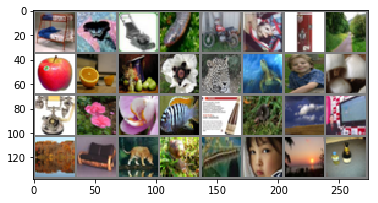

In [159]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

Uso l'80% del dataset per l'addestramento della rete, il restante 20% lo uso per fare test OOD

In [160]:
split = int(np.floor(len(train_loader.dataset.train_labels))*0.8)

train_l = train_loader.dataset.train_labels[0:split]
train_l = torch.IntTensor(train_l)

train_d = train_loader.dataset.train_data[0:split]
train_d = torch.FloatTensor(train_d)


val_l = train_loader.dataset.train_labels[split:-1]
val_l = torch.IntTensor(val_l)

val_d = train_loader.dataset.train_data[split:-1]
val_d = torch.FloatTensor(val_d)


test_lID = test_loader.dataset.test_labels
test_lID = torch.IntTensor(test_lID)

test_dID = test_loader.dataset.test_data
test_dID = torch.FloatTensor(test_dID)


test_lOD = test_loader.dataset.test_labels
test_lOD = torch.IntTensor(test_lOD)

test_dOD = test_loader.dataset.test_data
test_dOD = torch.FloatTensor(test_dOD)

Creo una funzione che mi separa i dataset e mette le etichette adeguate:

In [161]:
def createData(label, data, dim):
    zeros_d = data[label == 0]
    zeros_l = torch.zeros((len(zeros_d),))
    for i in (1, dim):
        nameNum_i = data[label == i]
        zeros_d = torch.cat([zeros_d, nameNum_i])
        if i == 1:
            zeros_l = torch.cat([zeros_l, torch.ones((len(nameNum_i),))])
        if i > 1:
            zeros_l = torch.cat([zeros_l, i*torch.ones((len(nameNum_i),))])
    zeros_d = zeros_d.type(torch.float32)
    return zeros_d, zeros_l

In [168]:
## Per il restante 20% serve far ripartire da zero le etichette quindi faccio una funzione adeguata
def createData20(label, data):
    eighty_d = data[label == 80]
    eighty_l = torch.zeros((len(eighty_d),))
    for i in (81, 99):
        nameNum_i = data[label == i]
        eighty_d = torch.cat([eighty_d, nameNum_i])
        tmp = i-80
        if tmp == 1:
            eighty_l = torch.cat([eighty_l, torch.ones((len(nameNum_i),))])
        if tmp > 1:
            eighty_l = torch.cat([eighty_l, i*torch.ones((len(nameNum_i),))])
    eighty_d = eighty_d.type(torch.float32)
    return eighty_d, eighty_l

In [163]:
#train loader da 0 a 79 80%
train_data, train_labels = createData(train_l, train_d, 79)
train_ds079 = TensorDataset(train_data, train_labels)
train_loader079 = torch.utils.data.DataLoader(train_ds079, batch_size=batch_size, shuffle=True, **kwargs)

print(len(train_leader079))

#validation loader da 0 a 79 20%
val_data, val_labels = createData(val_l, val_d, 79)
val_ds079 = TensorDataset(val_data, val_labels)
val_loader079 = torch.utils.data.DataLoader(val_ds079, batch_size=batch_size, shuffle=True, **kwargs)

print(len(val_loader079))

#test loaderOD da 80 a 99
testID_data, testID_labels = createData(test_lID, test_dID, 79)
test_dsID = TensorDataset(testID_data, testID_labels)
test_loaderID = torch.utils.data.DataLoader(test_dsID, batch_size=batch_size, shuffle=True, **kwargs)

print(len(test_loaderID))

#test loaderOD da 80 a 99
testOD_data, testOD_labels = createData20(test_lOD, test_dOD)
test_dsOD = TensorDataset(testOD_data, testOD_labels)
test_loaderOD = torch.utils.data.DataLoader(test_dsOD, batch_size=batch_size, shuffle=True, **kwargs)

print(len(test_loaderOD))

19
11
10
10


## Multi-layer Perceptron

In [164]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32*32, 128)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 128)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(128, 100)     # Numero di output 3.

    def forward(self, x):
        x = x.view(-1, 32*32)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), 1)

model = Net()
if cuda:
    model.cuda()
    
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

print(model)


Net(
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc1_drop): Dropout(p=0.2)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc2_drop): Dropout(p=0.2)
  (fc3): Linear(in_features=128, out_features=100, bias=True)
)


In [165]:
def train(epoch, log_interval, loader):
    model.train()
    batch_idx = 0
    while(batch_idx != len(loader)):
        for (data, target) in loader:
            target = target.type(torch.long)
            if cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(loader.dataset),
                    100. * batch_idx / len(loader), loss.item()))
            batch_idx = batch_idx + 1

In [166]:
def validate(loss_vector, accuracy_vector, loader):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in loader:
        target = target.type(torch.long)
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        val_loss += F.nll_loss(output, target).item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct / len(loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(loader.dataset), accuracy))

In [169]:
## Addestramento della rete su dataset0-79 con 3 epoche
epochs = 3

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch, 100, train_loader079)
    validate(lossv, accv, test_loader079)

ValueError: Expected input batch_size (96) to match target batch_size (32).